In [1]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import textstat

from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from sklearn.model_selection import train_test_split
from datasets import Dataset
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

%matplotlib inline

/home/trungnqcs/miniconda3/envs/llm-detect/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/trungnqcs/miniconda3/envs/llm-detect/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Original dataset - Introduction

- `train_essays.csv`: The training set with essays written by students and a few examples of LLM-generated essays.
- `test_essays.csv`: The test set with essays for which we need to predict whether they were generated by an LLM.
- `train_prompts.csv`: The prompts used to generate the essays, containing both the instructions and source texts.

In [3]:
# Define file paths
train_essays_path = '../data/original/train_essays.csv'
test_essays_path = '../data/original/test_essays.csv'
train_prompts_path = '../data/original/train_prompts.csv'

# Load the data
train_essays_df = pd.read_csv(train_essays_path)
test_essays_df = pd.read_csv(test_essays_path)
train_prompts_df = pd.read_csv(train_prompts_path)

In [3]:
# Display the few rows of the training essays
train_essays_df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [4]:
# Display the few rows of the test essays
test_essays_df.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [5]:
# Display rows of the train_prompts
train_prompts_df

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


## Original dataset - Exploratory Data Analysis (EDA)

In [6]:
# Check for missing values in the original dataset
missing_values_train = train_essays_df.isnull().sum()
print("missing_values_train:", missing_values_train)
missing_values_test = test_essays_df.isnull().sum()
print("\nmissing_values_test:", missing_values_test)
missing_values_prompts = train_prompts_df.isnull().sum()
print("\nmissing_values_prompts:", missing_values_prompts)

missing_values_train: id           0
prompt_id    0
text         0
generated    0
dtype: int64

missing_values_test: id           0
prompt_id    0
text         0
dtype: int64

missing_values_prompts: prompt_id       0
prompt_name     0
instructions    0
source_text     0
dtype: int64


In [7]:
def add_value_label(plt, x_list, y_list):
    for i in range(len(x_list)):
        plt.annotate(y_list[i], (i, y_list[i]), ha="center")

def show_bar_graph(labels, values, title, ylabel):
    plt.bar(labels, values, color=["coral", "lightgreen"])
    add_value_label(plt, labels, values)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

In [8]:
df_ai = train_essays_df[train_essays_df["generated"] == 1]
df_human = train_essays_df[train_essays_df["generated"] == 0]

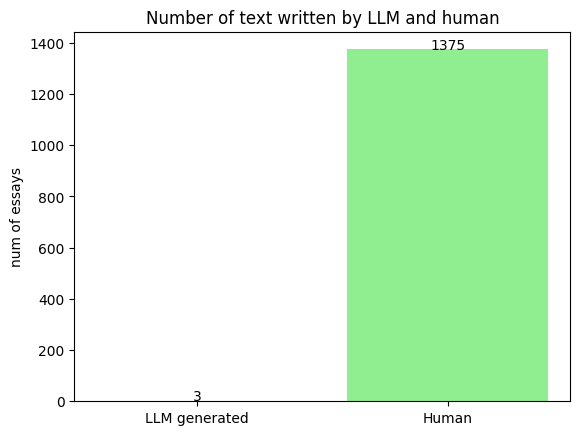

In [9]:
# Distribution of essays written by AI and human
labels = ['LLM generated', 'Human']
values = [len(df_ai), len(df_human)]

show_bar_graph(labels, values, "Number of text written by LLM and human", "num of essays")

The train_essays_df DataFrame reveals a highly imbalanced distribution with 1,375 student-written essays (label '0') and only 3 LLM-generated essays (label '1').

## DAIGT_V2 dataset - Introduction
* Since the original dataset given by the competition had very few number of data points and was highly imbalanced, DAIGT_V2 external dataset is chosen to tackle those problems.
- Link to the DAIGT_V2 on Kaggle: https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset

- `train_v2_drcat_02.csv`: The training set with essays written by students and LLM-generated.

In [2]:
# Define file path
daigt_train_essays_path = '../data/DAIGT_V2/train_v2_drcat_02.csv'

# Load the data
df_daigt_train = pd.read_csv(daigt_train_essays_path)

In [4]:
# Display the few rows of the training essays
df_daigt_train.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [12]:
# Display overall information about the dataset
df_daigt_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   label          44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


The dataset has 44868 rows and 5 columns.
* text: essay by student or machine
* label: 0 for humans, 1 for machine
* prompt_name: original persuade prompta
* source: source dataset
* RDizzl3_seven: Is from "7 Prompts training dataset" or not? refer to:https://www.kaggle.com/competitions/llm-detect-ai-generated-text/discussion/453410

## DAIGT_V2 dataset - Exploratory Data Analysis (EDA)

In [81]:
df_daigt_train

,text,label,prompt_name,source,RDizzl3_seven,essay_length
0,phone modern human today always phone always p...,0,Phones and driving,persuade_corpus,False,2029
1,essay explain driver able use electronic devic...,0,Phones and driving,persuade_corpus,False,2141
2,drive use cellular device today society though...,0,Phones and driving,persuade_corpus,False,1044
3,phone drive driver able use phone operate vehi...,0,Phones and driving,persuade_corpus,False,1243
4,cell phone operation drive ability stay connec...,0,Phones and driving,persuade_corpus,False,1911
...,...,...,...,...,...,...
44863,dear senator write today express view electora...,1,Does the electoral college work?,kingki19_palm,True,2239
44864,dear senator write today express support aboli...,1,Does the electoral college work?,kingki19_palm,True,2109
44865,dear senator write today express strong suppor...,1,Does the electoral college work?,kingki19_palm,True,1599
44866,dear senator write today express strong suppor...,1,Does the electoral college work?,kingki19_palm,True,1454


In [13]:
# Check for missing values in the DAIGT_V2 dataset
missing_values_train = df_daigt_train.isnull().sum()
print("missing_values_train:", missing_values_train)

missing_values_train: text             0
label            0
prompt_name      0
source           0
RDizzl3_seven    0
dtype: int64


In [14]:
# Check for duplicated data
df_daigt_train.duplicated().any()

False

In [15]:
df_daigt_ai = df_daigt_train[df_daigt_train["label"] == 1]
df_daigt_human = df_daigt_train[df_daigt_train["label"] == 0]

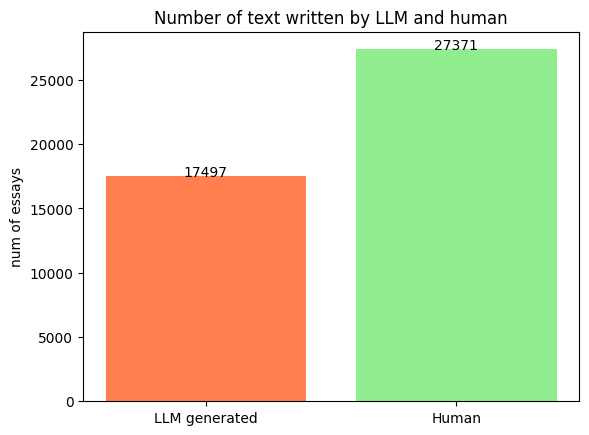

In [16]:
# Distribution of essays written by AI and human
labels = ['LLM generated', 'Human']
values = [len(df_daigt_ai), len(df_daigt_human)]

show_bar_graph(labels, values, "Number of text written by LLM and human", "num of essays")

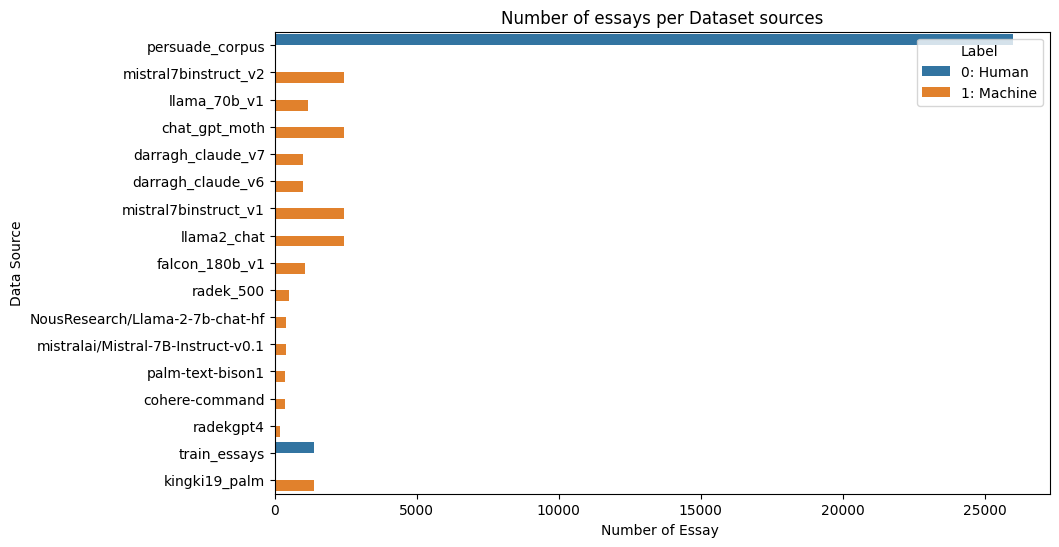

In [17]:
# Plot total number of essays distributed by each dataset sources of DAIGT_V2
plt.figure(figsize=(10,6))
sns.countplot(y='source', data=df_daigt_train, hue="label")
plt.title("Number of essays per Dataset sources")
plt.xlabel("Number of Essay ")
plt.ylabel("Data Source")
plt.legend(title='Label', loc='upper right', labels=['0: Human', '1: Machine'])
plt.show()

- The "persuade_corpus" dominates others in the number of essays. It should be noted that this dataset source contains 25,000 argumentative essays produced by 6th-12th grade students, without any LLM-generated essays.

- The "train_essays" is the original dataset we mentioned above.

- Other dataset sources contain essays generated by different LLMs.

Link to "persuade corpus 2.0" dataset: https://www.kaggle.com/datasets/nbroad/persaude-corpus-2/

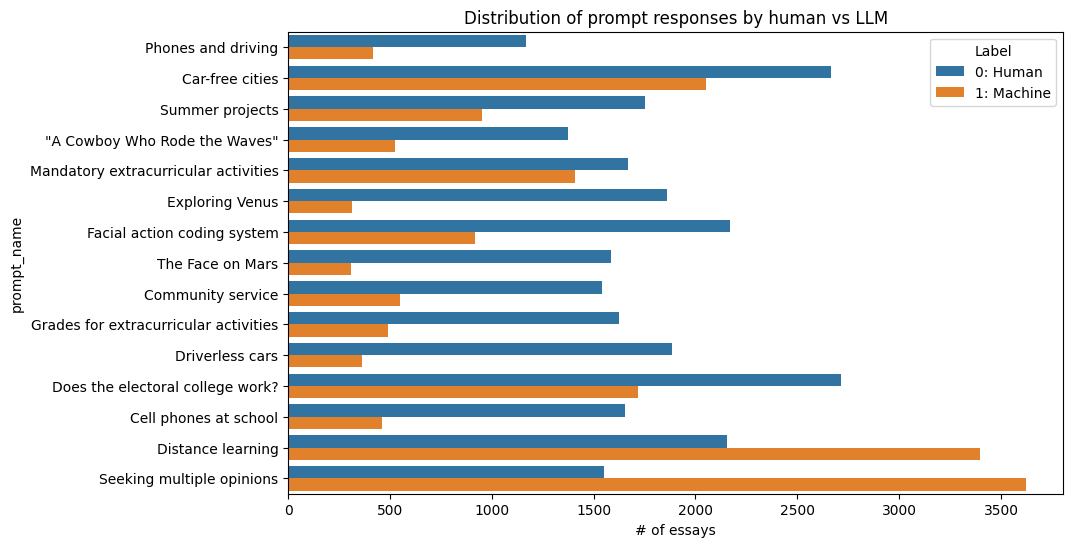

In [18]:
plt.figure(figsize=(10,6))
sns.countplot(df_daigt_train, y="prompt_name", hue="label")
plt.title("Distribution of prompt responses by human vs LLM")
plt.xlabel("# of essays")
plt.legend(title='Label', loc='upper right', labels=['0: Human', '1: Machine'])
plt.show()

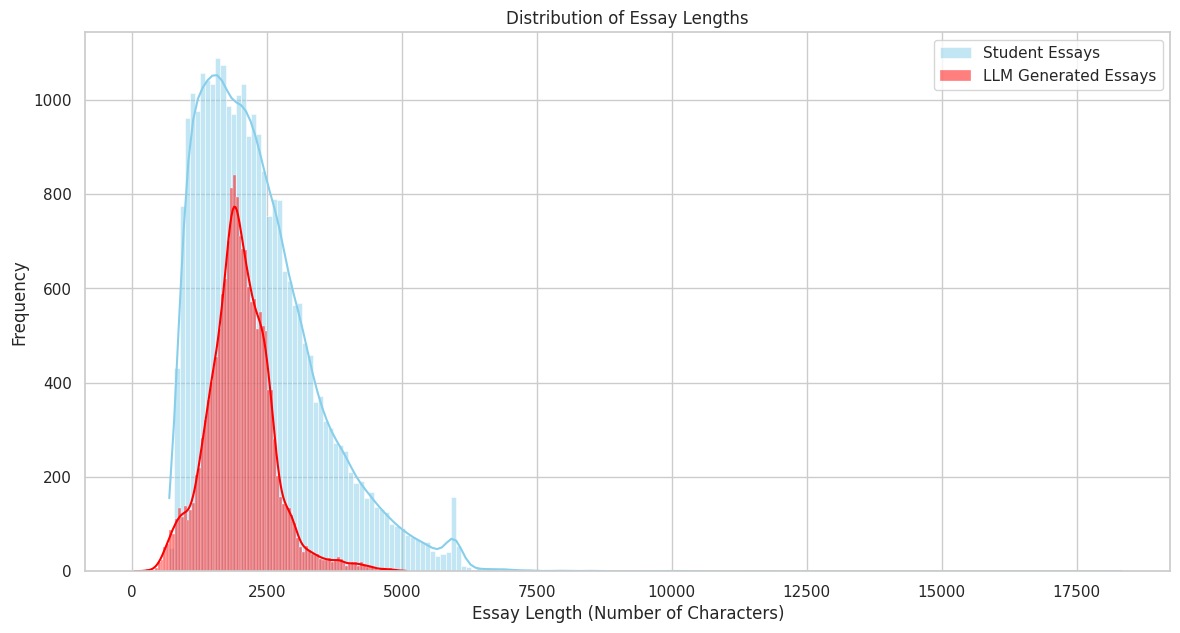

In [19]:
#Plot the essay lengths of human vs LLM
df_daigt_train['essay_length'] = df_daigt_train['text'].apply(len)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Distribution of essay lengths for student essays
sns.histplot(df_daigt_train[df_daigt_train['label'] == 0]['essay_length'], color="skyblue", label='Student Essays', kde=True)

# Distribution of essay lengths for LLM generated essays
sns.histplot(df_daigt_train[df_daigt_train['label'] == 1]['essay_length'], color="red", label='LLM Generated Essays', kde=True)

plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Essay length varies widely for students and is typically longer than LLM-generated essays.

In [20]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# df = pd.read_csv('data.csv')

# Lemmazation
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if no match

def preprocess_text(text):
    # Remove non-alphanumeric characters (excluding spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Normalize whitespace to a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenize text into words
    words = word_tokenize(text.lower())  # Convert to lowercase
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    
    # Get part of speech for each filtered word
    pos_tags = nltk.pos_tag(filtered_words)
    
    # Lemmatize words using their part of speech
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    
    # Rejoin lemmatized words into a single string
    cleaned_text = ' '.join(lemmatized_words)
    
    return cleaned_text

df_daigt_train['text'] = df_daigt_train['text'].apply(preprocess_text)
df_daigt_train.to_csv('preprocessed_daigt_v2.csv', index=False)

[nltk_data] Downloading package punkt to /home/trungnqcs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/trungnqcs/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/trungnqcs/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/trungnqcs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_data = pd.read_csv("preprocessed_daigt_v2.csv")
df_daigt_ai = df_data[df_data["label"] == 1]
df_daigt_human = df_data[df_data["label"] == 0]

In [22]:
########################## Statistics BEFORE preprocessing data ##########################

# Get lists of human vs LLM essays BEFORE preprocessing
human_essays = df_daigt_human['text'].str.lower().tolist()
llm_essays = df_daigt_ai['text'].str.lower().tolist()

# Get lists of human vs LLM essays tokens BEFORE preprocessing
human_tokens_before_preprocessing = [nltk.word_tokenize(essay) for essay in human_essays]
human_tokens_before_preprocessing = [w for doc in human_tokens_before_preprocessing for w in doc]

llm_tokens_before_preprocessing = [nltk.word_tokenize(essay) for essay in llm_essays]
llm_tokens_before_preprocessing = [w for doc in llm_tokens_before_preprocessing for w in doc]

# Get human vs LLM vocab BEFORE preprocessing
human_vocab_before_preprocessing = set(human_tokens_before_preprocessing)
llm_vocab_before_preprocessing = set(llm_tokens_before_preprocessing)

print("--------------- BEFORE preprocessing ---------------")
print("Number of tokens of HUMAN WRITTEN essays: ", len(human_tokens_before_preprocessing))
print("Number of tokens of LLM GENERATED essays: ", len(llm_tokens_before_preprocessing))
print("Length of HUMAN WRITTEN essays vocabulary: ", len(human_vocab_before_preprocessing))
print("Length of LLM GENERATED essays vocabulary: ", len(llm_vocab_before_preprocessing))


# ########################## Statistics AFTER preprocessing data ##########################

# Get lists of human vs LLM essays tokens AFTER preprocessing
human_tokens_after_preprocessing = [nltk.word_tokenize(preprocess_text(essay)) for essay in human_essays]
human_tokens_after_preprocessing = [w for doc in human_tokens_after_preprocessing for w in doc]

llm_tokens_after_preprocessing = [nltk.word_tokenize(preprocess_text(essay)) for essay in llm_essays]
llm_tokens_after_preprocessing = [w for doc in llm_tokens_after_preprocessing for w in doc]

# Get human vs LLM vocab AFTER preprocessing
human_vocab_after_preprocessing = set(human_tokens_after_preprocessing)
llm_vocab_after_preprocessing = set(llm_tokens_after_preprocessing)

print("\n\n--------------- AFTER preprocessing ---------------")
print("Number of tokens of HUMAN WRITTEN essays: ", len(human_tokens_after_preprocessing))
print("Number of tokens of LLM GENERATED essays: ", len(llm_tokens_after_preprocessing))
print("Length of HUMAN WRITTEN essays vocabulary: ", len(human_vocab_after_preprocessing))
print("Length of LLM GENERATED essays vocabulary: ", len(llm_vocab_after_preprocessing))

--------------- BEFORE preprocessing ---------------
Number of tokens of HUMAN WRITTEN essays:  5716727
Number of tokens of LLM GENERATED essays:  3144129
Length of HUMAN WRITTEN essays vocabulary:  78506
Length of LLM GENERATED essays vocabulary:  21360


--------------- AFTER preprocessing ---------------
Number of tokens of HUMAN WRITTEN essays:  5707096
Number of tokens of LLM GENERATED essays:  3139849
Length of HUMAN WRITTEN essays vocabulary:  77543
Length of LLM GENERATED essays vocabulary:  20689


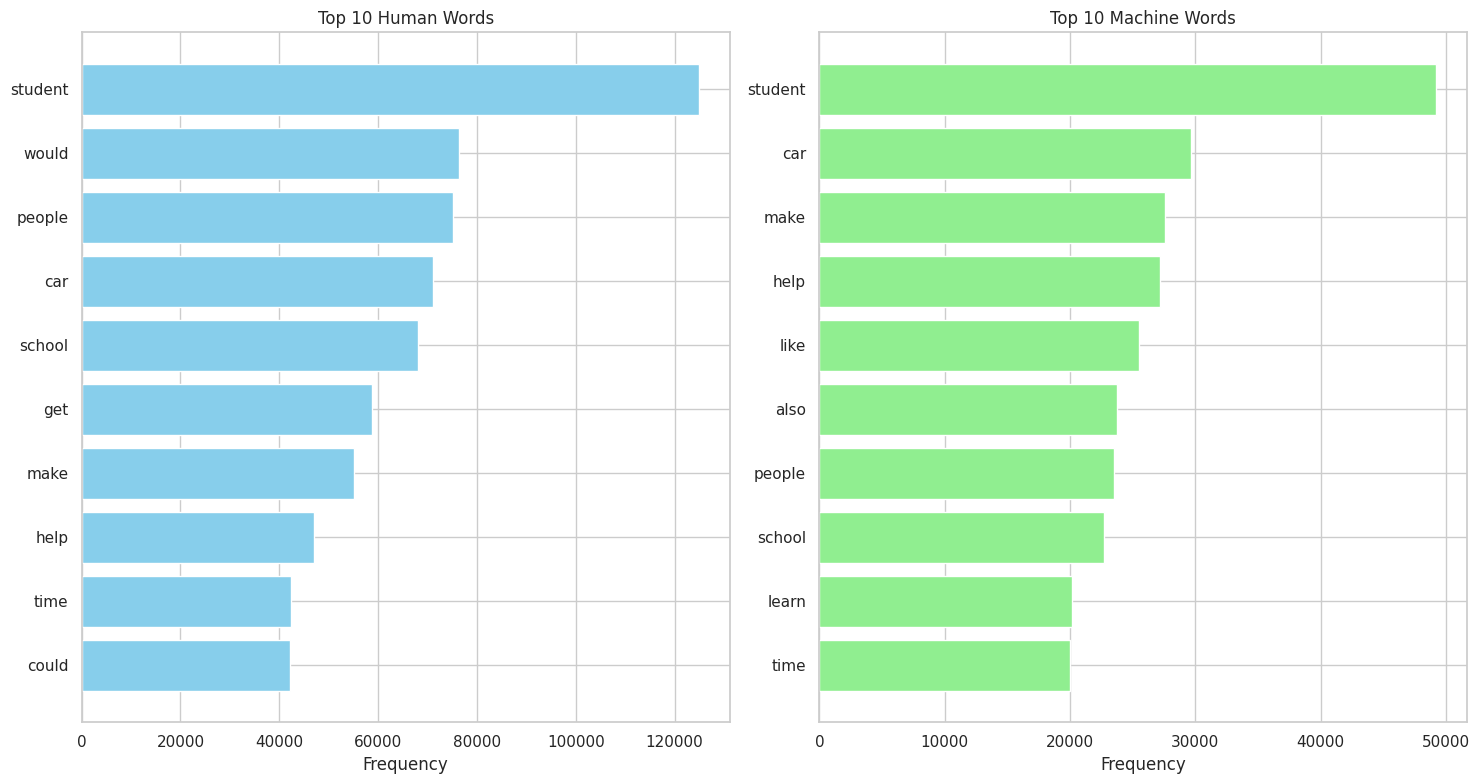

In [24]:
from collections import Counter

top_10_human = Counter(human_tokens_after_preprocessing).most_common(10)
top_10_machine = Counter(llm_tokens_after_preprocessing).most_common(10)

# Separate words and counts for human and machine
human_words, human_counts = zip(*top_10_human)
machine_words, machine_counts = zip(*top_10_machine)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Human bar chart
axs[0].barh(human_words, human_counts, color='skyblue')
axs[0].set_title('Top 10 Human Words')
axs[0].set_xlabel("Frequency")
axs[0].invert_yaxis()

# Machine bar chart
axs[1].barh(machine_words, machine_counts, color='lightgreen')
axs[1].set_title('Top 10 Machine Words')
axs[1].set_xlabel("Frequency")
axs[1].invert_yaxis()

# Layout adjustments
plt.tight_layout()
plt.savefig('top10.png')


# NLP Characteristics Analysis

## 1. Lexical analysis

In [25]:
from nltk import download
from nltk.tokenize import word_tokenize
from scipy.stats import mannwhitneyu
import numpy as np


# Filter data for 'Phones and driving' prompt if necessary
# data = data[data['prompt_name'] == 'Phones and driving']

# Separate the dataset into human and AI-generated texts
human_texts = df_data[df_data['label'] == 0]['text']
ai_texts = df_data[df_data['label'] == 1]['text']

# Tokenize and calculate total TTR for human texts
human_tokens = [word_tokenize(text) for text in human_texts]
human_flat_tokens = [token for sublist in human_tokens for token in sublist]
human_types = set(human_flat_tokens)
human_ttr = len(human_types) / len(human_flat_tokens)

# Tokenize and calculate total TTR for AI texts
ai_tokens = [word_tokenize(text) for text in ai_texts]
ai_flat_tokens = [token for sublist in ai_tokens for token in sublist]
ai_types = set(ai_flat_tokens)
ai_ttr = len(ai_types) / len(ai_flat_tokens)

# Calculate MSTTR for human texts by dividing texts into segments of 100 tokens
human_segment_ttrs = []
for tokens in human_tokens:
    for i in range(0, len(tokens), 100):
        segment = tokens[i : i + 100]
        segment_types = set(segment)
        segment_ttr = len(segment_types) / len(segment) if segment else 0
        human_segment_ttrs.append(segment_ttr)
human_msttr = np.mean(human_segment_ttrs)

# Calculate MSTTR for AI texts by dividing texts into segments of 100 tokens
ai_segment_ttrs = []
for tokens in ai_tokens:
    for i in range(0, len(tokens), 100):
        segment = tokens[i:i+100]
        segment_types = set(segment)
        segment_ttr = len(segment_types) / len(segment) if segment else 0
        ai_segment_ttrs.append(segment_ttr)
ai_msttr = np.mean(ai_segment_ttrs)

# Perform Mann-Whitney U test on segment TTRs
u_statistic, p_value = mannwhitneyu(human_segment_ttrs, ai_segment_ttrs)

print("\n\n---------------- Lexical Analysis ----------------")
print(f"Human TTR: {human_ttr}, AI TTR: {ai_ttr}")
print(f"Human MSTTR: {human_msttr}, AI MSTTR: {ai_msttr}")
print(f"Mann-Whitney U Statistic: {u_statistic}, P-Value: {p_value}")




---------------- Lexical Analysis ----------------
Human TTR: 0.013732683054482048, AI TTR: 0.006793614384142635
Human MSTTR: 0.7211715823368656, AI MSTTR: 0.7531750518998453
Mann-Whitney U Statistic: 1209064003.5, P-Value: 0.0


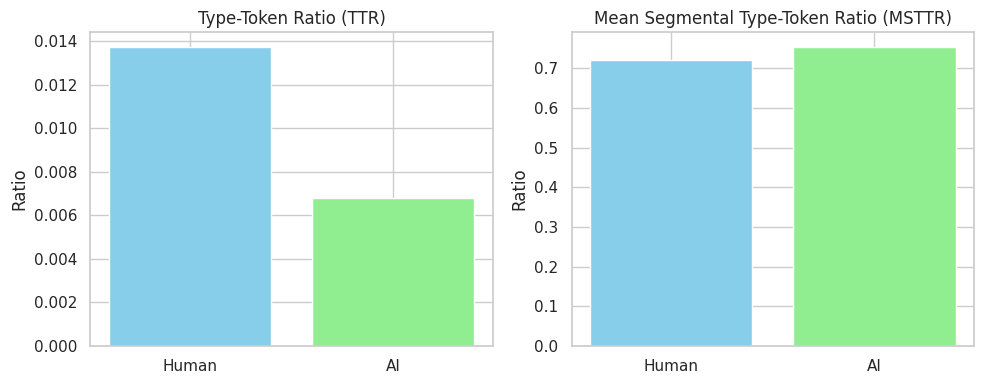

In [26]:
import matplotlib.pyplot as plt

# Data for plotting
categories = ['Human', 'AI']
ttr_values = [human_ttr, ai_ttr]
msttr_values = [human_msttr, ai_msttr]

# Creating the bar chart
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# TTR Plot
ax[0].bar(categories, ttr_values, color=['skyblue', 'lightgreen'])
ax[0].set_title('Type-Token Ratio (TTR)')
ax[0].set_ylabel('Ratio')

# MSTTR Plot
ax[1].bar(categories, msttr_values, color=['skyblue', 'lightgreen'])
ax[1].set_title('Mean Segmental Type-Token Ratio (MSTTR)')
ax[1].set_ylabel('Ratio')

plt.tight_layout()
plt.show()


## 2. Linguistic Analysis

### 2.1 NER/POS tagging

In [45]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag, ne_chunk
from nltk.tree import Tree
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/trungnqcs/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/trungnqcs/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [49]:
import spacy
nlp = spacy.load("en_core_web_md")

def extract_NER_POS(text):
    tokens = nlp(text) # put text to the model and perform tokenization internally

    NER = [(ent.text, ent.label_) for ent in tokens.ents]

    POS =  [(token.text, token.pos_) for token in tokens]

    return pd.Series([NER, POS])

df_data[['NER', 'POS']] = df_data['text'].apply(extract_NER_POS)

In [ ]:
# store as csv, since running NER and POS takes 20 mins
# df_data.to_csv("after_NER_POS.csv")

In [50]:
import pandas as pd
df = pd.read_csv("after_NER_POS.csv",index_col=0)

In [51]:
# create a list of entity types
entity_types = [
    "PERSON", "NORP", "FAC", "ORG", "GPE", "LOC", "PRODUCT",
    "EVENT", "WORK_OF_ART", "LAW", "LANGUAGE", "DATE", "TIME",
    "PERCENT", "MONEY", "QUANTITY", "ORDINAL", "CARDINAL"
]

# create a dictionary to store entities by type for each row
entities_by_type = {etype: [] for etype in entity_types}

# iterate over the df
for index, row in df.iterrows():
    NER = eval(row['NER'])

    # extract entities for each type and add to the entities_by_type dictionary
    for etype in entity_types:
        entities_by_type[etype].append([n for n, e in NER if e == etype])

In [52]:
# put entities to the original df
for etype in entity_types:
    df[etype] = entities_by_type[etype]

In [53]:
# POS tags
pos_tags = [
    "ADJ", "ADP", "ADV", "AUX", "CONJ", "CCONJ",
    "DET", "INTJ", "NOUN", "NUM", "PART", "PRON",
    "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X",
    "SPACE"
]

# initialize a dictionary to store lists of words by their POS tag
pos_data = {pos_tag: [] for pos_tag in pos_tags}

# iterate over the df, extracting words for each POS tag
for _, row in df.iterrows():
    pos_list = eval(row['POS'])
    for pos_tag in pos_tags:
        # Extract words for the current POS tag
        words = [word for word, tag in pos_list if tag == pos_tag]
        pos_data[pos_tag].append(words)

# convert the pos_data dictionary to a DataFrame for easy viewing or further processing
pos_df = pd.DataFrame(pos_data)

# combine the POS data with the original DataFrame
combined_df = pd.concat([df, pos_df], axis=1)

In [54]:
# filter to positive and negative df
# treat llm essay as positive
positive_df = combined_df[combined_df['label'] == 1]
negative_df = combined_df[combined_df['label'] == 0]

In [55]:
# adding all entities by types to their list for the positive sentiment
positive_NER = {E:[] for E in entity_types}

for _, row in positive_df.iterrows():
    for e in positive_NER.keys():
        positive_NER[e] += row[e]


positive_NER_count = {k:len(v) for k,v in positive_NER.items()}

In [56]:
# adding all entities by types to their list for the negative sentiment
negative_NER = {E:[] for E in entity_types}

for _, row in negative_df.iterrows():
    for e in negative_NER.keys():
        negative_NER[e] += row[e]


negative_NER_count = {k:len(v) for k,v in negative_NER.items()}

In [57]:
def percentage_diff(llm,human):
    res = []
    if len(llm) != len(human):
        return -1
    for l,h in zip(llm,human):
        # if the denominator is 0
        if h == 0:
            res.append(0)
        else:
            res.append( (l-h) /h )
    return np.array(res)

In [58]:
count_human_essays = len(df[df['label']==0])
count_llm_essays = len(df[df['label']!=0])

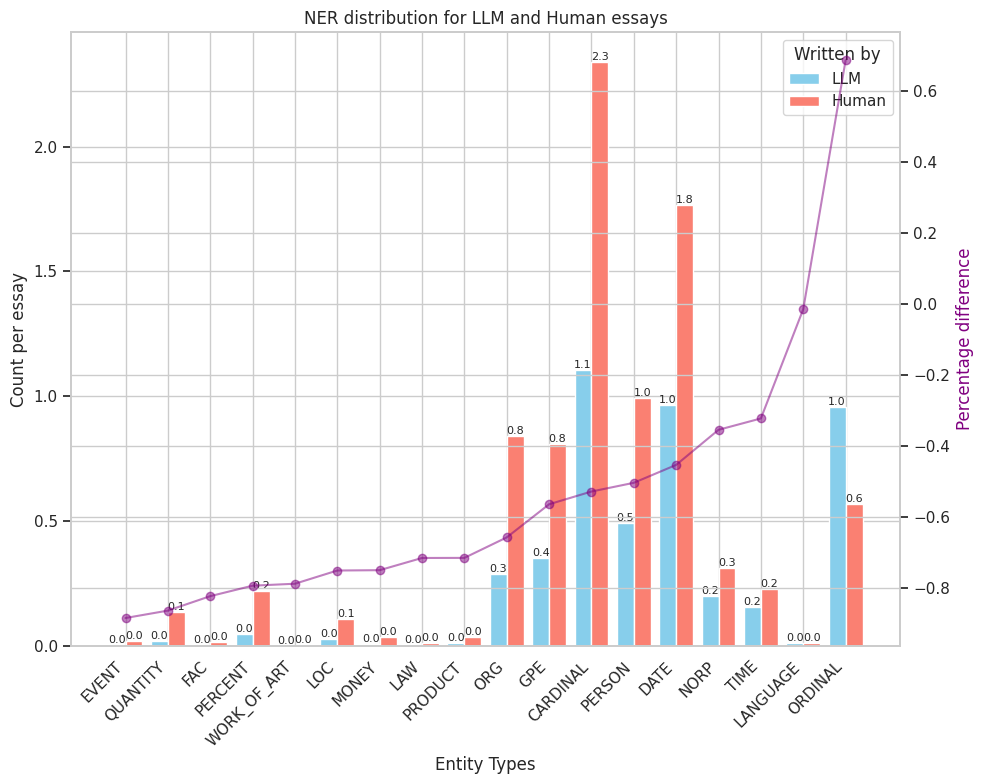

In [59]:
# plot double barchart for NER among positive and negative sentiment
fig, ax = plt.subplots(figsize=(10, 8))

X_axis = np.arange(len(positive_NER_count.keys()))

# LLM per essay
llm_NER_per_essay = np.array(list(positive_NER_count.values())) / count_llm_essays
human_NER_per_essay = np.array(list(negative_NER_count.values())) / count_human_essays

diff_NER = percentage_diff(llm_NER_per_essay,human_NER_per_essay)

# Sort the categories based on percentage difference
sorted_indices = np.argsort(diff_NER)

# Apply the sorted indices to entity types and count arrays
sorted_entity_types = np.array(list(positive_NER_count.keys()))[sorted_indices]
sorted_llm_NER_per_essay = llm_NER_per_essay[sorted_indices]
sorted_human_NER_per_essay = human_NER_per_essay[sorted_indices]
sorted_diff_NER = diff_NER[sorted_indices]

# Positive(LLM) bar chart
ax.bar(X_axis - 0.2,sorted_llm_NER_per_essay,0.4,
       color='skyblue',label='LLM')
# Negative(Human) bar chart
ax.bar(X_axis + 0.2,sorted_human_NER_per_essay,0.4,
       color='salmon',label="Human")
ax.set_title('NER distribution for LLM and Human essays')
ax.set_xlabel('Entity Types')
ax.set_ylabel('Count per essay')
ax.set_xticks(X_axis)
ax.set_xticklabels(sorted_entity_types)

ax.legend(title="Written by")

# Adding numbers on top of the LLM bars
for i, value in enumerate(sorted_llm_NER_per_essay):
    ax.text(i - 0.2, value, f"{value:.1f}", ha='center', va='bottom',fontsize=8)

# Adding numbers on top of the Human bars
for i, value in enumerate(sorted_human_NER_per_essay):
    ax.text(i + 0.2, value, f"{value:.1f}", ha='center', va='bottom',fontsize=8)

plt.xticks(rotation=45, ha="right")
# Create a second y-axis for the second scale
ax2 = ax.twinx()
ax2.plot( sorted_diff_NER, color='purple', label='Percentage difference', marker='o', alpha=0.5 )  # Using a line plot here for demonstration
ax2.set_ylabel('Percentage difference', color='purple')
plt.tight_layout()
plt.show()

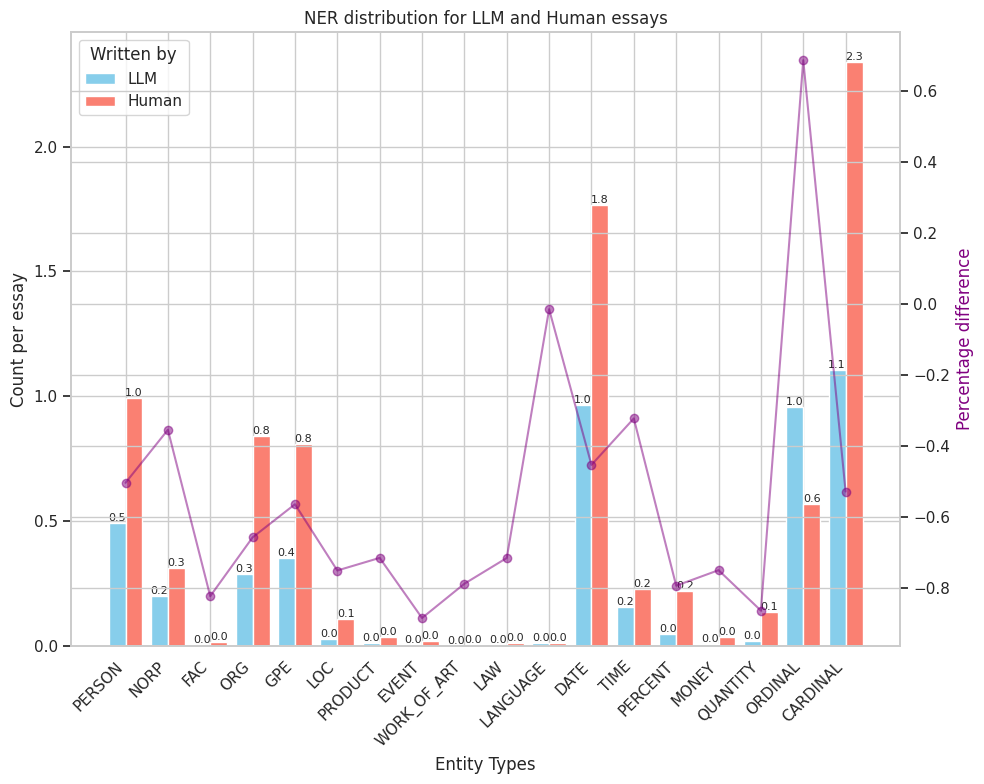

In [60]:
# plot double barchart for NER among positive and negative sentiment
fig, ax = plt.subplots(figsize=(10, 8))

X_axis = np.arange(len(positive_NER_count.keys()))

# LLM per essay
llm_NER_per_essay = np.array(list(positive_NER_count.values()))/count_llm_essays
human_NER_per_essay = np.array(list(negative_NER_count.values()))/count_human_essays

diff_NER = percentage_diff(llm_NER_per_essay,human_NER_per_essay)



# Positive(LLM) bar chart
ax.bar(X_axis - 0.2,llm_NER_per_essay,0.4,
       color='skyblue',label='LLM')
# Negative(Human) bar chart
ax.bar(X_axis + 0.2,human_NER_per_essay,0.4,
       color='salmon',label="Human")
ax.set_title('NER distribution for LLM and Human essays')
ax.set_xlabel('Entity Types')
ax.set_ylabel('Count per essay')
ax.set_xticks(X_axis)
ax.set_xticklabels(positive_NER_count.keys())

ax.legend(title="Written by")

# Adding numbers on top of the LLM bars
for i, value in enumerate(llm_NER_per_essay):
    ax.text(i - 0.2, value, f"{value:.1f}", ha='center', va='bottom',fontsize=8)

# Adding numbers on top of the Human bars
for i, value in enumerate(human_NER_per_essay):
    ax.text(i + 0.2, value, f"{value:.1f}", ha='center', va='bottom',fontsize=8)

plt.xticks(rotation=45, ha="right")
# Create a second y-axis for the second scale
ax2 = ax.twinx()
ax2.plot( diff_NER, color='purple', label='Percentage difference', marker='o', alpha=0.5 )  # Using a line plot here for demonstration
ax2.set_ylabel('Percentage difference', color='purple')
plt.tight_layout()
plt.show()

In [61]:
# adding all POS-tag to their list for the positive sentiment
positive_POS = {E:[] for E in pos_tags}

for _, row in positive_df.iterrows():
    for pos_tag in positive_POS.keys():
        positive_POS[pos_tag] += row[pos_tag]


positive_POS_count = {k:len(v) for k,v in positive_POS.items()}

In [62]:
# adding all POS-tag to their list for the negative sentiment
negative_POS = {E:[] for E in pos_tags}

for _, row in negative_df.iterrows():
    for pos_tag in negative_POS.keys():
        negative_POS[pos_tag] += row[pos_tag]


negative_POS_count = {k:len(v) for k,v in  negative_POS.items()}

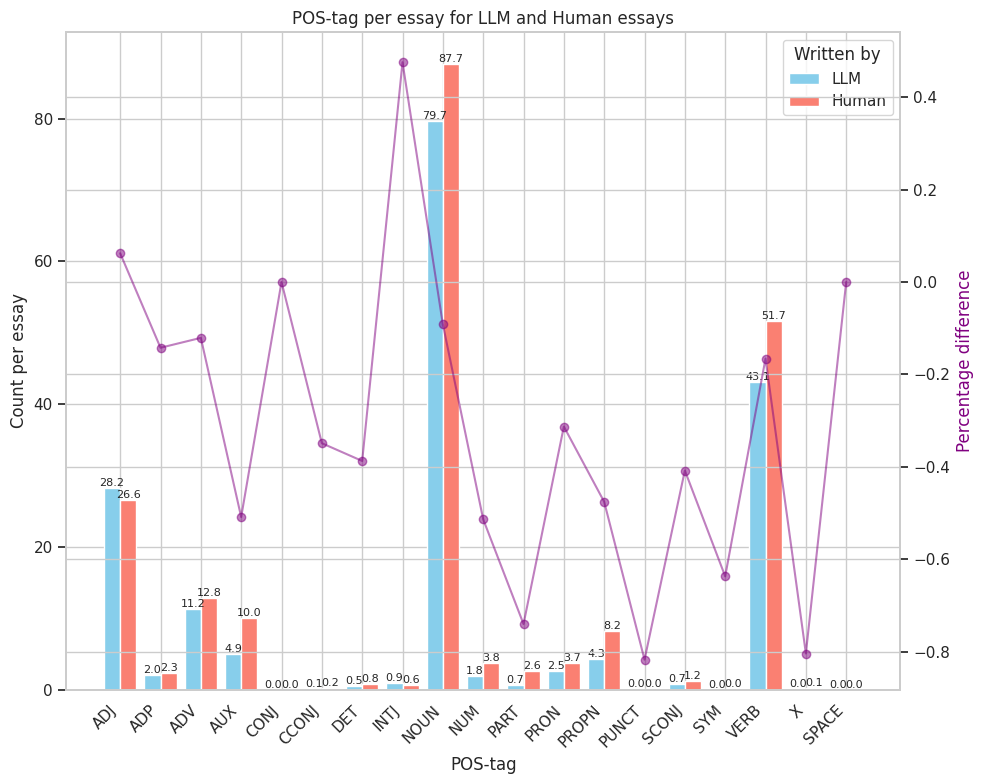

In [63]:
# plot double barchart for POS-tag among positive and negative sentiment
fig, ax = plt.subplots(figsize=(10, 8))

X_axis = np.arange(len(positive_POS_count.keys()))

# LLM per essay
llm_POS_per_essay = np.array(list(positive_POS_count.values()))/count_llm_essays
human_POS_per_essay = np.array(list(negative_POS_count.values()))/count_human_essays


# percentage difference
diff_POS = percentage_diff(llm_POS_per_essay,human_POS_per_essay)

# Positive bar
ax.bar(X_axis - 0.2, llm_POS_per_essay ,0.4,
       color='skyblue',label='LLM')
# Negative bar
ax.bar(X_axis + 0.2, human_POS_per_essay ,0.4,
       color='salmon',label="Human")



ax.set_title('POS-tag per essay for LLM and Human essays')
ax.set_ylabel('Count per essay')
ax.set_xlabel('POS-tag')



ax.legend(title="Written by")

# Adding numbers on top of the LLM bars
for i, value in enumerate(llm_POS_per_essay):
    ax.text(i - 0.2, value, f"{value:.1f}", ha='center', va='bottom',fontsize=8)

# Adding numbers on top of the Human bars
for i, value in enumerate(human_POS_per_essay):
    ax.text(i + 0.2, value, f"{value:.1f}", ha='center', va='bottom',fontsize=8)

# set xticks
ax.set_xticks(X_axis)
ax.set_xticklabels(positive_POS_count.keys())

plt.xticks(rotation=45, ha="right")

# Create a second y-axis for the second scale
ax2 = ax.twinx()
ax2.plot( diff_POS, color='purple', label='Percentage difference', marker='o', alpha=0.5 )  # Using a line plot here for demonstration
ax2.set_ylabel('Percentage difference', color='purple')

plt.tight_layout()
plt.show()

## 3. Sentiment analysis

In [65]:
import spacy
nlp = spacy.load("en_core_web_md")
from textblob import TextBlob

def extract_sentiment(text):
    blob = TextBlob(text).sentiment

    Polarity = blob.polarity

    Subjectivity =  blob.subjectivity

    return pd.Series([Polarity, Subjectivity])

df[['Polarity', 'Subjectivity']] = df['text'].apply(extract_sentiment)

In [66]:
llm_df = df[df['label'] == 1]
human_df = df[df['label'] == 0]

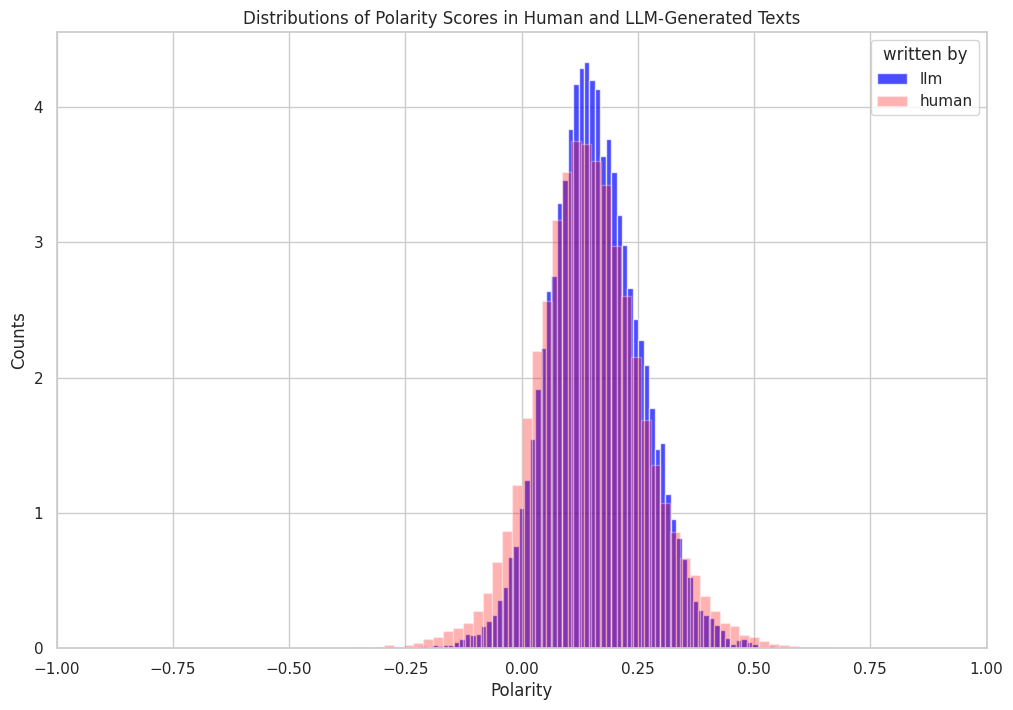

In [80]:
fig,ax = plt.subplots(figsize=(12,8))

plt.hist(llm_df['Polarity'],bins=80,alpha=0.7,color='blue',label='llm',density=True)
plt.hist(human_df['Polarity'],bins=80,alpha=0.3,color='red',label='human',density=True)

plt.ylabel("Counts")
plt.xlabel('Polarity')
plt.title('Distributions of Polarity Scores in Human and LLM-Generated Texts')
plt.legend(title="written by")
plt.xlim((-1,1))
plt.show()

## 4. Advanced analysis

### 4.1 Coherence analysis

In [71]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import pandas as pd

# Load the data
# df = preprocessed_df

# Converting text columns to lists of words lists
texts = [text.split() for text in df['text'].astype(str)]

# Creating dictionaries and corpus
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Traning LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10)

# Calculate the coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score:', coherence_lda)


Coherence Score: 0.4378917769409248


In [75]:
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import optuna
import numpy as np

# load the dataset
texts = [text.split() for text in df['text'].astype(str)]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

def optimize_lda(trial):
    # defining a hyperparametric search space for LDA models
    num_topics = trial.suggest_categorical('num_topics', [10, 15, 20, 25, 30])
    alpha = trial.suggest_categorical('alpha', ['symmetric', 'asymmetric', 'auto'])
    eta = trial.suggest_categorical('eta', ['symmetric', 'auto'])

    # training LDA model
    model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     alpha=alpha,
                     eta=eta,
                     random_state=42)

    # calculate and return a consistency score
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    return coherence_score

# Create an optuna research object and perform optimization
study = optuna.create_study(direction='maximize')
study.optimize(optimize_lda, n_trials=20)

# Output the optimal parameters and score
print(f"Best parameters: {study.best_params}")
print(f"Best coherence score: {study.best_value}")


[I 2024-04-04 04:36:50,457] A new study created in memory with name: no-name-80a74ec8-cf9d-43d0-ac02-6f30eb6c47c2
[I 2024-04-04 04:37:17,907] Trial 0 finished with value: 0.5044380036937199 and parameters: {'num_topics': 25, 'alpha': 'symmetric', 'eta': 'symmetric'}. Best is trial 0 with value: 0.5044380036937199.
[I 2024-04-04 04:37:35,832] Trial 1 finished with value: 0.5262511250448234 and parameters: {'num_topics': 10, 'alpha': 'auto', 'eta': 'symmetric'}. Best is trial 1 with value: 0.5262511250448234.
[I 2024-04-04 04:38:19,621] Trial 2 finished with value: 0.472933512044838 and parameters: {'num_topics': 30, 'alpha': 'asymmetric', 'eta': 'symmetric'}. Best is trial 1 with value: 0.5262511250448234.
[I 2024-04-04 04:38:50,519] Trial 3 finished with value: 0.48976370285318505 and parameters: {'num_topics': 30, 'alpha': 'symmetric', 'eta': 'auto'}. Best is trial 1 with value: 0.5262511250448234.
[I 2024-04-04 04:39:11,787] Trial 4 finished with value: 0.5351457909979106 and paramet

Best parameters: {'num_topics': 15, 'alpha': 'auto', 'eta': 'auto'}
Best coherence score: 0.5944542283322248


# Modelling

In [3]:
LOWERCASE = False
VOCAB_SIZE = 14000000

In [4]:
df_train, df_test, y_train, y_test = train_test_split(
    df_daigt_train.drop(columns=['label'], axis=1), 
    df_daigt_train.label, test_size=0.2, random_state=42
)

In [5]:
# Creating Byte-Pair Encoding tokenizer
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

# Adding normalization and pre_tokenizer
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

# Adding special tokens and creating trainer instance
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

# Creating huggingface dataset object
dataset = Dataset.from_pandas(df_test[['text']])

def train_corp_iter():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]
        
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)
tokenized_texts_test = []

for text in tqdm(df_test['text'].tolist()):
    tokenized_texts_test.append(tokenizer.tokenize(text))

tokenized_texts_train = []

for text in tqdm(df_train['text'].tolist()):
    tokenized_texts_train.append(tokenizer.tokenize(text))

100%|██████████| 35894/35894 [00:18<00:00, 1983.05it/s]


In [6]:
def dummy(text):
    return text

vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer = 'word',
    tokenizer = dummy,
    preprocessor = dummy,
    token_pattern = None, strip_accents='unicode')

vectorizer.fit(tokenized_texts_test)

# Getting vocab
vocab = vectorizer.vocabulary_

# print(vocab)

vectorizer = TfidfVectorizer(
    ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
    analyzer = 'word',
    tokenizer = dummy,
    preprocessor = dummy,
    token_pattern = None, 
    strip_accents='unicode'
)

tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

del vectorizer
gc.collect()

0

In [7]:
# MultinomialNB model
clf_MNB = MultinomialNB()
clf_MNB.fit(tf_train, y_train)
y_pred_train = clf_MNB.predict(tf_train)
y_pred_test = clf_MNB.predict(tf_test)

# print(classification_report(y_test, y_pred))
print("Train ROC AUC score: ", roc_auc_score(y_train, y_pred_train))
print("Test ROC AUC score: ", roc_auc_score(y_test, y_pred_test))

Train ROC AUC score:  0.9840402742073693
Test ROC AUC score:  0.9804931885299517


In [8]:
# SGD model
clf_SGD = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber")
clf_SGD.fit(tf_train, y_train)
y_pred_test = clf_SGD.predict(tf_train)
y_pred_test = clf_SGD.predict(tf_test)

print("Train ROC AUC score: ", roc_auc_score(y_train, y_pred_train))
print("Test ROC AUC score: ", roc_auc_score(y_test, y_pred_test))

Train ROC AUC score:  0.9840402742073693
Test ROC AUC score:  0.9759519038076152


In [ ]:
# LGBM model
# p6={
#     'n_iter': 1750,'verbose': -1,'objective': 'binary',
#     'metric': 'auc','learning_rate': 0.05073909898961407,
#     'colsample_bytree': 0.726023996436955, 'colsample_bynode': 0.5803681307354022,
#     'lambda_l1': 8.562963348932286, 'lambda_l2': 4.893256185259296,
#     'min_data_in_leaf': 115, 'max_depth': 23, 'max_bin': 898
# }
params = {
        'n_iter': 3000,
        'verbose': -1,
        'objective': 'cross_entropy',
        'metric': 'auc',
        'learning_rate': 0.00581909898961407, 
        'colsample_bytree': 0.78,
        'colsample_bynode': 0.5,
        'random_state': 6743
}
clf_LGBM = LGBMClassifier(**params)

clf_LGBM.fit(tf_train, y_train)


In [10]:
y_pred_train = clf_LGBM.predict(tf_train)
y_pred_test = clf_LGBM.predict(tf_test)

print("Train ROC AUC score: ", roc_auc_score(y_train, y_pred_train))
print("Test ROC AUC score: ", roc_auc_score(y_test, y_pred_test))

Train ROC AUC score:  0.9997857754927164
Test ROC AUC score:  0.9459956219682569


In [11]:
# Ensemble 3 models
ensemble = VotingClassifier(estimators=[('mnb', clf_MNB), ('sgd', clf_SGD), ('lgb', clf_LGBM)],
                            weights=[0.3,0.3,0.4], voting='soft', n_jobs=-1)

ensemble.fit(tf_train, y_train)
y_pred_train_ensemble = ensemble.predict(tf_train)
y_pred_test_ensemble = ensemble.predict(tf_test)

print("Train ROC AUC score: ", roc_auc_score(y_train, y_pred_train_ensemble))
print("Test ROC AUC score: ", roc_auc_score(y_test, y_pred_test_ensemble))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Train ROC AUC score:  0.9975364181662383
Test ROC AUC score:  0.9719438877755511


In [ ]:
# clf_cat = CatBoostClassifier(
# #         iterations=3000,
#         iterations=1200,
#         verbose=0,
#         random_seed=6543,
# #         learning_rate=0.005599066836106983,
#         learning_rate=0.01,
#         subsample = 0.35,
#         allow_const_label=True,
#         loss_function = 'CrossEntropy'
#     )

# clf_cat.fit(tf_train, y_train)
# y_pred = clf_cat.predict(tf_test)

# print("ROC AUC score: ", roc_auc_score(y_test, y_pred))

In [ ]:
# # Ensemble 4 models
# ensemble = VotingClassifier(estimators=[('mnb', clf_MNB), ('sgd', clf_SGD), ('lgb', clf_LGBM), ('cat', clf_cat)],
#                             weights=[0.1,0.31,0.28,0.67], voting='soft', n_jobs=-1)
# ensemble.fit(tf_train, y_train)
# y_pred = ensemble.predict(tf_test)

# print("ROC AUC score: ", roc_auc_score(y_test, y_pred))